# Signal Preprocessing and Analysis

### This notebook objective is to analyze raw signal dataset representing time-series data from urine spectrometry measurements

### Imports

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, detrend, find_peaks, peak_widths, welch
from scipy.stats import entropy


### Uploading the data

In [2]:
data = pd.read_csv('signal.csv')
data.head(10)

,Unnamed: 0,Time,Noisy_Trended_Signal
0,0,0.00000,-0.212277
1,1,0.01001,0.249596
2,2,0.02002,0.507517
3,3,0.03003,0.836112
4,4,0.04004,1.088553
5,5,0.05005,1.184766
6,6,0.06006,1.389889
7,7,0.07007,1.328603
8,8,0.08008,1.413306
9,9,0.09009,1.377757


### Data Handeling

In [3]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head(10)

,Time,Noisy_Trended_Signal
0,0.00000,-0.212277
1,0.01001,0.249596
2,0.02002,0.507517
3,0.03003,0.836112
4,0.04004,1.088553
5,0.05005,1.184766
6,0.06006,1.389889
7,0.07007,1.328603
8,0.08008,1.413306
9,0.09009,1.377757


#### Handeling NaN values

In [4]:
data.isnull().sum()

,0
Time,0
Noisy_Trended_Signal,0


There are not NaN values

### Preprocessing

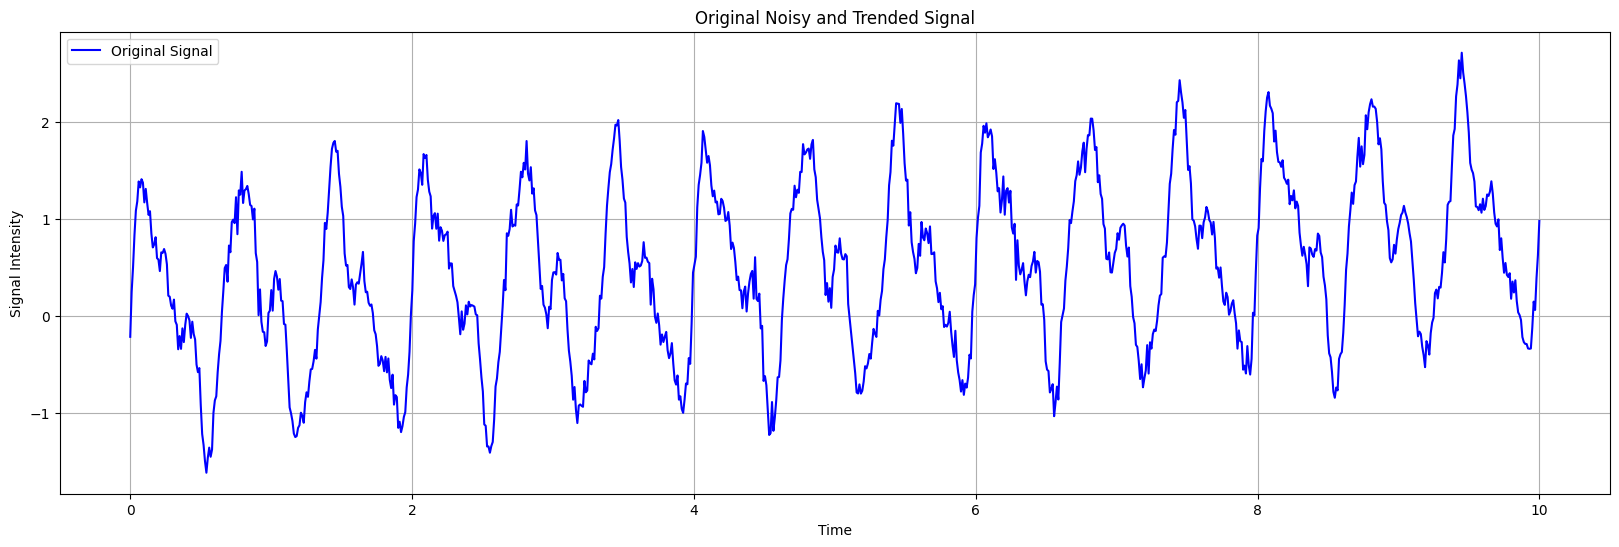

In [5]:
fig = plt.figure(figsize=(20, 6))
plt.plot(data['Time'], data['Noisy_Trended_Signal'], label='Original Signal', color='blue')
plt.title('Original Noisy and Trended Signal')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.grid(True)
plt.legend()
plt.show()

#### Filtering

I decided to apply Low-pass filter.
Low pass filter passes signals with a frequency lower than a certain cutoff frequency and weaken signals with frequencies higher than the cutoff frequency.

In [6]:
def low_pass_filter(signal, cutoff_frequency, sampling_rate, order=4):
    """
    Apply a low-pass filter to a signal.
    Parameters:
    - signal: The input signal to be filtered.
    - cutoff_frequency: The cutoff frequency for the filter.
    - sampling_rate: The sampling rate of the signal.
    - order: The order of the Butterworth filter.
    """
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

* sampling rate of a signal is the ratio between the number of samples and the total time in seconds
* cuttoff frequency determines which part of the frequency spectrum of the signal will be retained and which will be attenuated or removed.

Finding the sampling rate

In [7]:
n = len(data['Noisy_Trended_Signal'])

sampling_rate = n / 10 # number of samples / time in seconds
print(f"Sampling Rate: {sampling_rate}")

Sampling Rate: 100.0


Finding the cuttoff frequency

Max Peak: 5.0

Cutoff Frequency: 7.5



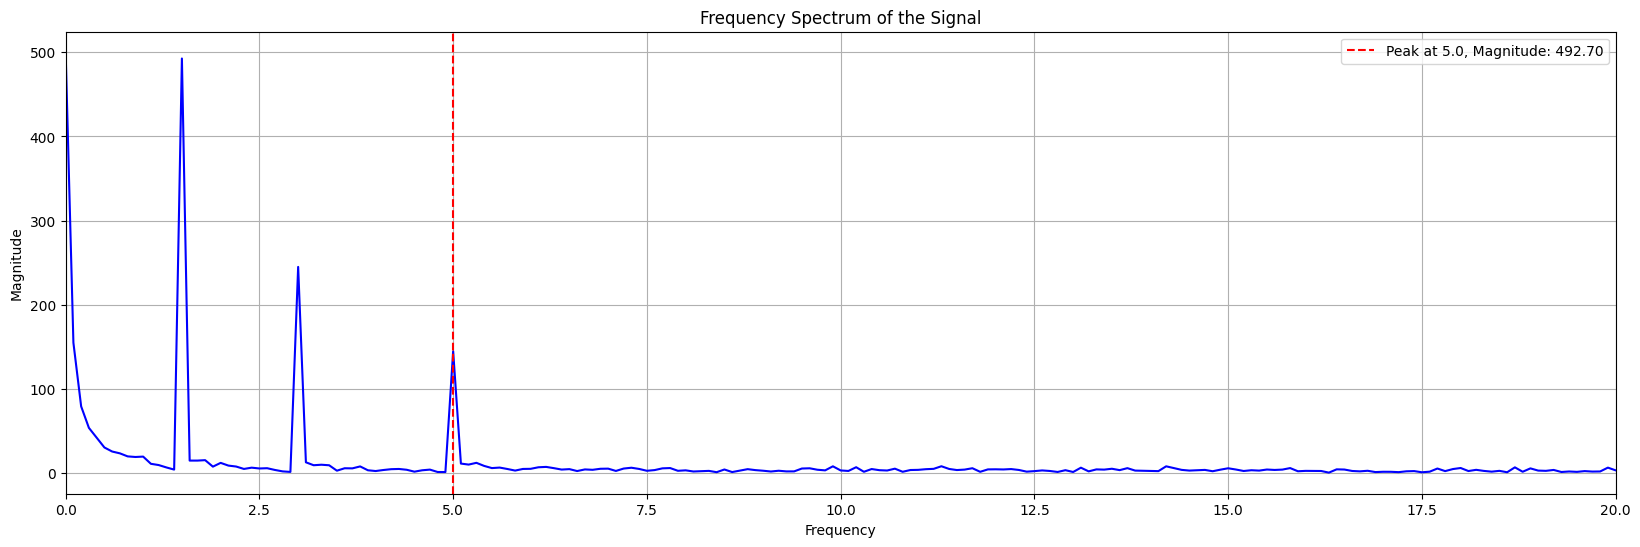

In [8]:
# FFT
fft_values = np.fft.fft(data['Noisy_Trended_Signal'])
fft_frequencies = np.fft.fftfreq(n, d=1/sampling_rate)

# Only take the positive half of the spectrum
positive_freqs = fft_frequencies[:n//2]
positive_magnitude = np.abs(fft_values[:n//2])

peaks, _ = find_peaks(positive_magnitude, height=np.max(positive_magnitude)*0.1)

if len(peaks) > 0: # Finding the max peak, if there is
    max_peak_freq = positive_freqs[peaks].max()
    print(f"Max Peak: {max_peak_freq}\n")

    max_peak_magnitude = positive_magnitude[peaks].max()
    cutoff_frequency = max_peak_freq * 1.5
else: # default if no peaks were found
    cutoff_frequency = 1.0

print(f"Cutoff Frequency: {cutoff_frequency}\n")

plt.figure(figsize=(20, 6))
plt.plot(positive_freqs, positive_magnitude, color='blue')
plt.axvline(x=max_peak_freq, color='red', linestyle='--', label=f'Peak at {max_peak_freq}, Magnitude: {max_peak_magnitude:.2f}')

# Set the x-limit to zoom into the area of interest
plt.xlim(0, 20)
plt.title('Frequency Spectrum of the Signal')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.grid()
plt.show()

As can be seen, the maximal peak is at 5. Afterwards the frequecneis

Applying low-pass filter for noise reduction

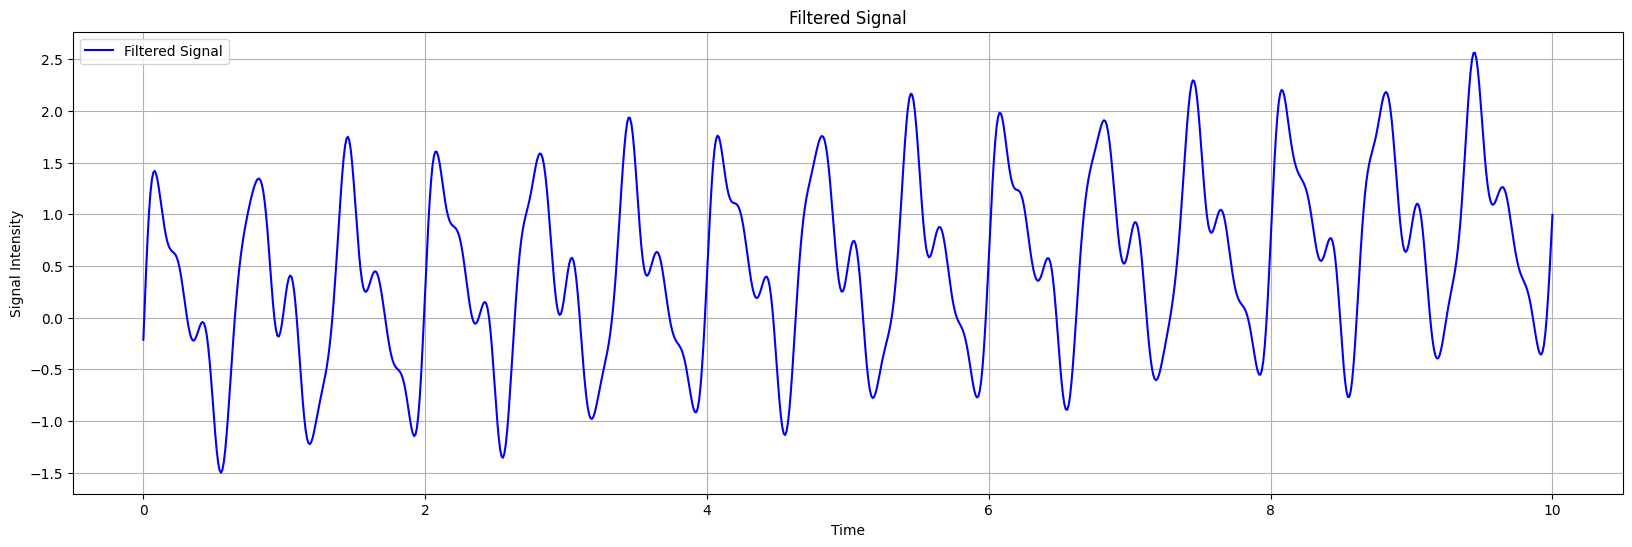

In [9]:
filtered_signal = low_pass_filter(data['Noisy_Trended_Signal'], cutoff_frequency, sampling_rate)

fig = plt.figure(figsize=(20, 6))
plt.plot(data['Time'], filtered_signal, label='Filtered Signal', color='blue')
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.grid(True)
plt.legend()
plt.show()

#### Detrending

Detrending is a common technique to remove underlying trends or biases from a signal. It usefull for feature extraction and focus on variations.

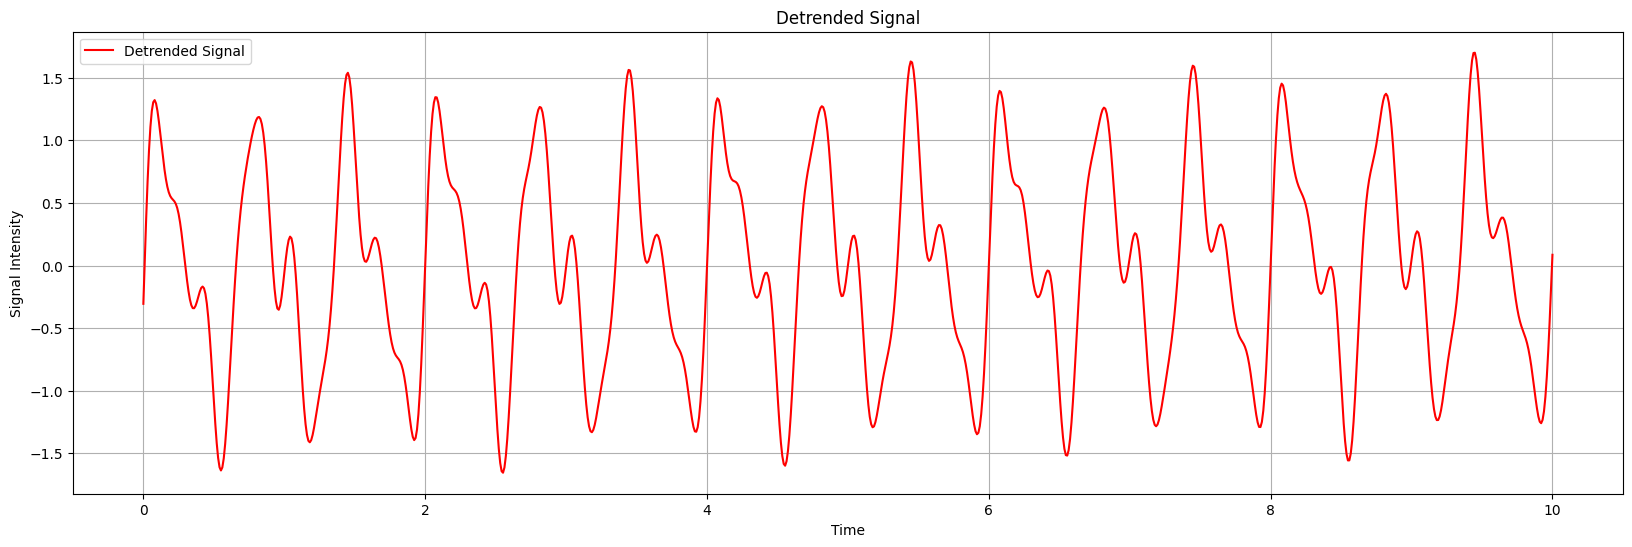

In [10]:
detrended_signal = detrend(filtered_signal)

fig = plt.figure(figsize=(20, 6))
plt.plot(data['Time'], detrended_signal, label='Detrended Signal', color='red')
plt.title('Detrended Signal')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.grid(True)
plt.legend()
plt.show()

#### Normalization

 Using Min-Max Normalization. It scales the data to a specific range (between 0 and 1). This technique is particularly useful when you want to bring different signals into the same range for comparison or further analysis.

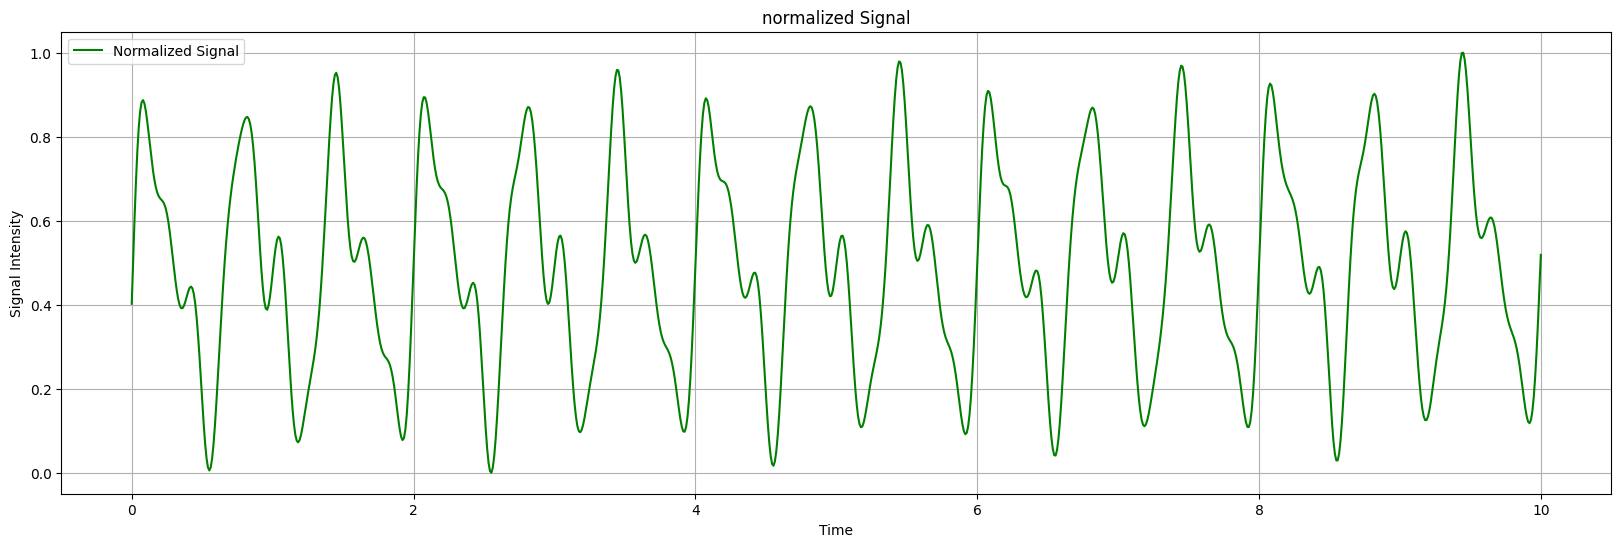

In [11]:
normalized_signal = (detrended_signal - detrended_signal.min()) / (detrended_signal.max() - detrended_signal.min())

fig = plt.figure(figsize=(20, 6))
plt.plot(data['Time'], normalized_signal, label='Normalized Signal', color='green')
plt.title('normalized Signal')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.grid(True)
plt.legend()
plt.show()

#### Looking at all plots together to see differences

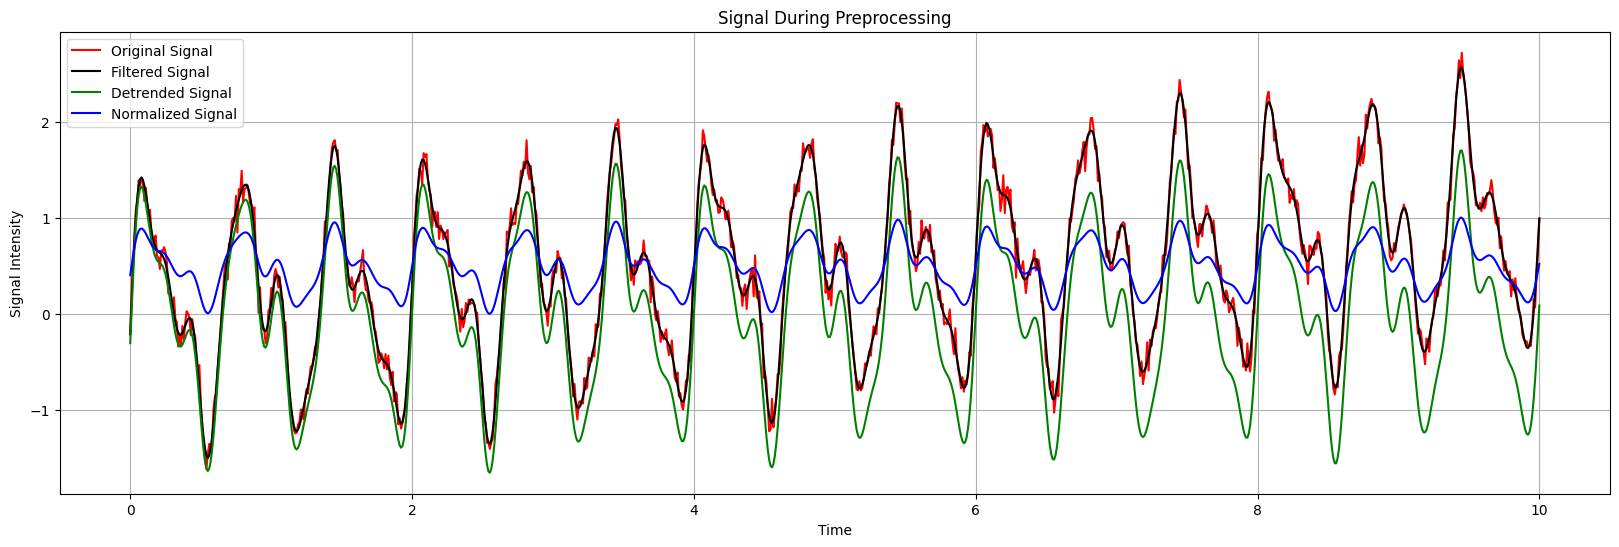

In [12]:
fig = plt.figure(figsize=(20, 6))

plt.plot(data['Time'], data['Noisy_Trended_Signal'], label='Original Signal', color='red')
plt.plot(data['Time'], filtered_signal, label='Filtered Signal', color='black')
plt.plot(data['Time'], detrended_signal, label='Detrended Signal', color='green')
plt.plot(data['Time'], normalized_signal, label='Normalized Signal', color='blue')
plt.title('Signal During Preprocessing')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.grid(True)
plt.legend()
plt.show()

The chainging of the signal during the preprocessing process can easly seen.
* The original signal, colored by red.
* The filtered signal, after noise reduction colored by black.
* The detrended signal, colored by green.
* The normalized signal.

### Frequency Analysis

#### Fast Fourier Transform (FFT)

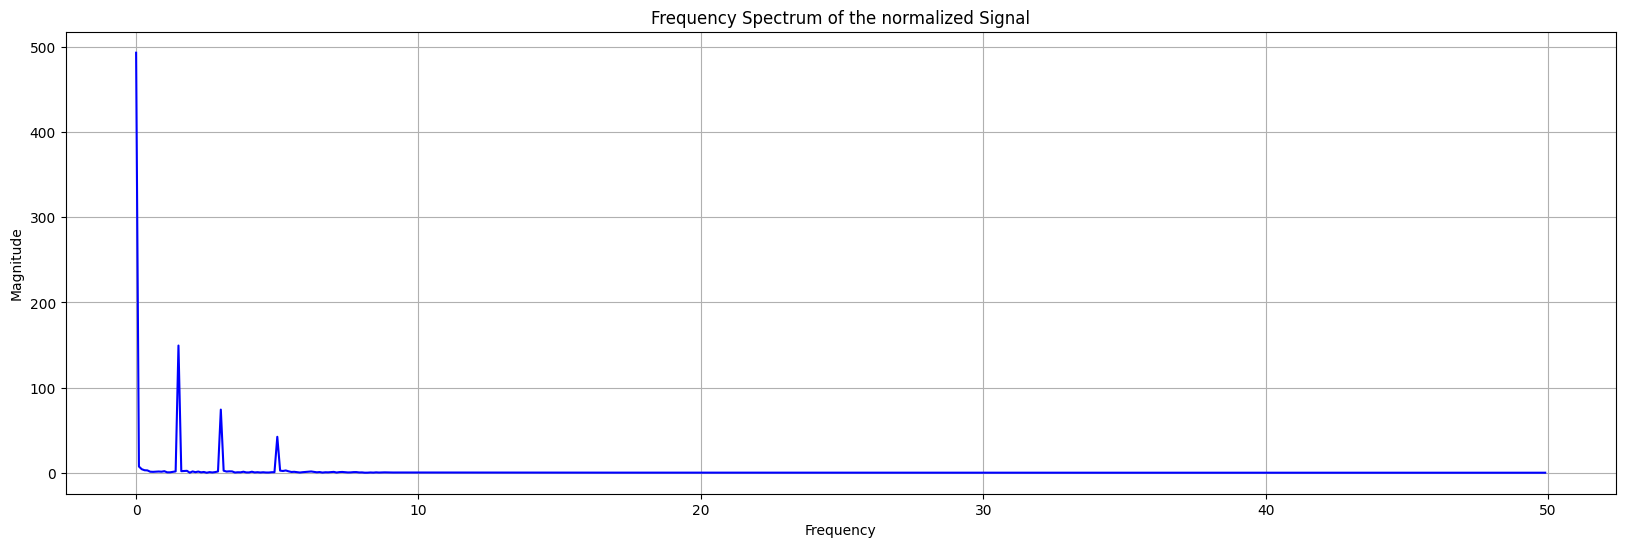

In [31]:
normalized_fft_values = np.fft.fft(normalized_signal)
normalized_fft_frequencies = np.fft.fftfreq(n, d=1/sampling_rate) # sampling rate equals to 100 as before
normalized_magnitude = np.abs(normalized_fft_values)

# Plot the frequency spectrum
plt.figure(figsize=(20, 6))
plt.plot(normalized_fft_frequencies[:n // 2], normalized_magnitude[:n // 2], color='blue')  # Plot only positive frequencies
plt.title('Frequency Spectrum of the normalized Signal')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

#### significant frequency components

* The most noticeable peak is near 0 Hz, which usually points to a strong DC component steady-state or average value of a signal over time). or a shift in the baseline of the signal. In biological signals, this kind of peak might represent slow or almost constant processes, possibly connected to the concentration or baseline levels of a substance in the urine.

* There are smaller peaks around 2 Hz, 4 Hz, 6 Hz, and a few others in the low-frequency range. These peaks are likely connected to repeating patterns in the signal. In the context of urine analysis, these repeating patterns might be linked to regular changes in certain chemical or physical properties in the urine, such as the concentration of substances, pH fluctuations, or other cyclical processes that might be important.

* The signal is contians alot low-frequency parts, with very little high-frequency content above 10 Hz. This suggests that the chemical processes or signals in the urine are slow and don't involve quick changes.

**Potential Relevance to Chemical Processes**

* Metabolic Cycles: The low-frequency parts might show signs of metabolic cycles or regulatory processes (temperature Regulation, blood Sugar Regulation, blood Pressure Regulation). For example, the peaks could be connected to the circadian rhythm or other slow biochemical processes that influence the makeup of urine.

* The strong DC component and low-frequency fluctuations might also mean that the urine is in a fairly stable chemical balance, with small changes on the levels of different substances.

* Noise Filtering: The lack of high-frequency components might suggest that noise filtering process was usefull.


### Feature Extraction and Engineering

Peak Frequencies and Amplitudes

Peak frequencies and amplitudes can be very usefull for predictive models.
* Datas sets, especially time series data can be high-dimensional and complex. Finding its peak frequencies and amplitudes helps to summarize the signal with a few key features.
* Many time series data contain periodic patterns or cycles. Peak frequencies represent these periodic components, allowing the model the recognize and leverage these patterns.
* Peak frequencies and amplitudes can be very informative. These features can capture important aspects of the data, improving the model's ability to make accurate predictions. For example, in medical diagnostics, specific frequency patterns in  biochemical signals may be indicative of certain health conditions (as I described before).

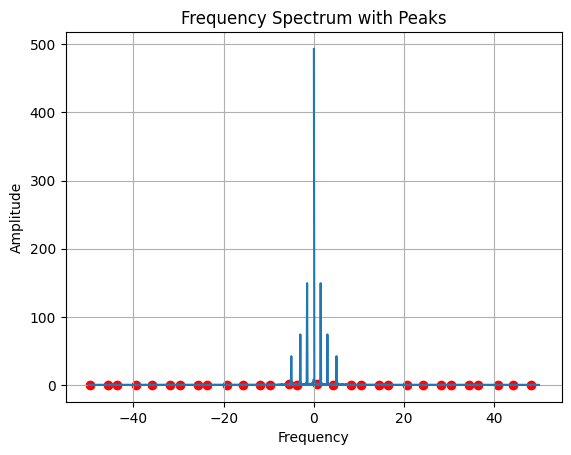

Peak Frequencies: [  0.8   4.2   8.2  10.4  14.5  16.4  20.7  24.2  28.1  30.4  34.4  36.4
  40.7  44.2  48.1 -49.6 -45.6 -43.6 -39.3 -35.9 -31.9 -29.7 -25.6 -23.6
 -19.3 -15.8 -11.9  -9.7  -5.6  -3.7]
Peak Amplitudes: [1.5339961  0.43791846 0.17802505 0.30224592 0.25084377 0.21899516
 0.17685566 0.15450578 0.1372483  0.12966809 0.11973381 0.11599152
 0.11011776 0.10717076 0.1055553  0.10537235 0.10639739 0.1075709
 0.11173544 0.1168607  0.12551251 0.13180927 0.14754558 0.15777554
 0.1885472  0.22992431 0.30607645 0.36479379 1.18053928 0.56813758]


In [20]:
peaks, _ = find_peaks(normalized_signal)
peak_frequencies = normalized_fft_frequencies[peaks]
peak_amplitudes = normalized_magnitude[peaks]

plt.figure()
plt.plot(normalized_fft_frequencies, normalized_magnitude)
plt.scatter(peak_frequencies, peak_amplitudes, color='red')
plt.title('Frequency Spectrum with Peaks')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

print(f"Peak Frequencies: {peak_frequencies}")
print(f"Peak Amplitudes: {peak_amplitudes}")

* Peak frequencies in the signal range from 0.8 Hz to 48.1 Hz, indicating various periodic components. Frequencies like 0.8 Hz, 4.2 Hz, and 8.2 Hz have the highest amplitudes, showing dominant periodic patterns.

* The highest amplitude of 1.53 at 0.8 Hz signifies its major impact on the signal. Stronger amplitudes in lower frequencies suggest dominant, slower-varying patterns in the data.

* Positive and negative frequencies in the Fourier Transform reflect symmetric properties in real-valued signals, indicating real oscillatory behavior.

* Top frequencies with the highest amplitudes can be used as features for machine learning, helping in classification and anomaly detection.

* Analyzing peak amplitude ratios and frequency distribution provides insights into signal characteristics, such as low-frequency versus high-frequency dominance.

* Peak count and spread across frequencies help assess signal complexity, with high density suggesting complex patterns and low density indicating simpler trends.

#### spectral entropy

Spectral Entropy is useful for machine learning tasks, especially with time series data. It captures the complexity and unpredictability of signals by measuring the distribution of power across different frequency bands. This feature is robust to noise and can help distinguish between normal and abnormal patterns. It's effective in various domains like biomedical signal processing (as ours), speech recognition, finance, and anomaly detection. Spectral entropy complements other features like peak frequency and amplitude, enriching the feature set and improving model performance and generalization.

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


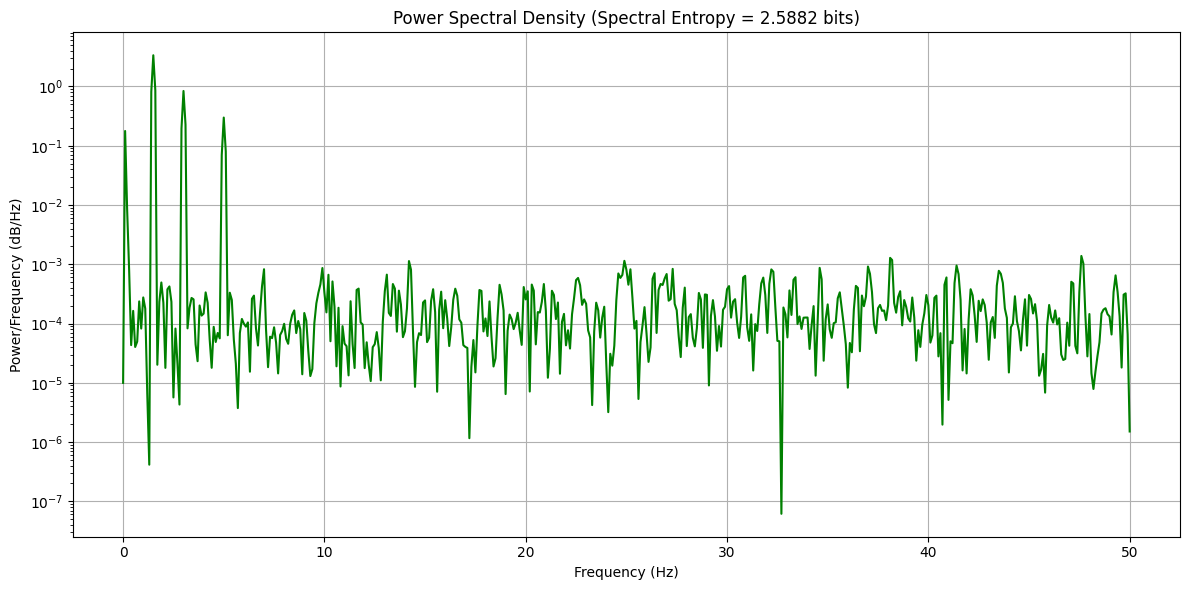

In [30]:
frequencies, psd = welch(data['Noisy_Trended_Signal'], sampling_rate, nperseg=1024)

psd_normalized = psd / np.sum(psd)

# Calculate spectral entropy
spectral_entropy = entropy(psd_normalized, base=2)

plt.figure(figsize=(12, 6))
# Plot PSD
plt.semilogy(frequencies, psd, color='green')
plt.title(f'Power Spectral Density (Spectral Entropy = {spectral_entropy:.4f} bits)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.tight_layout()
plt.show()

**Observations**

* The PSD plot shows strong peaks at lower frequencies, which means the signal has regular repeating patterns or cycles. These peaks indicate where most of the signal's energy is concentrated, corresponding to the periodic behavior seen in the time-domain plot.


* While most of the energy is at lower frequencies, the PSD plot also shows some energy spread across a range of frequencies. This spread suggests that the signal is not purely periodic and contains other frequency components, likely due to noise or smaller fluctuations.


* The spectral entropy (~2.5882 bits) measures how complex and unpredictable the signal is. A moderate entropy value suggests the signal has both regular patterns and some randomness. If the entropy were lower, it would mean the signal is more predictable. A higher entropy would indicate more randomness.


* The PSD plot's energy spread indicates that the signal includes not only periodic components but also some random noise. This matches what we see in the original signal plot, where regular cycles are mixed with random variations.


* By analyzing the PSD and entropy, we can extract useful features for machine learning. For example, identifying the main frequency peaks, understanding the spread of power, and using the entropy value can help us classify signals, detect anomalies, or understand different types of patterns.
